# IND320 Part 3, Jupyter Notebook

This notebook covers:
1) Cities and price areas for Norway  
2) ERA5 historical downloader and Bergen 2019 example  
3) Temperature outliers using DCT high pass with robust SPC  
4) Precipitation anomalies using LOF  
5) STL decomposition on elhub production data  
6) Spectrogram on elhub production data


## Setup
Imports plus plotting defaults.

In [1]:
# Global imports for the whole notebook

# Core
import os
import time
from datetime import datetime, timedelta, timezone

# Data and math
import numpy as np
import pandas as pd

# HTTP
import requests

# Plotting
import matplotlib.pyplot as plt

# Stats and ML
from statsmodels.tsa.seasonal import STL
from sklearn.neighbors import LocalOutlierFactor

# Signals
from scipy.fftpack import dct, idct
from scipy.signal import spectrogram as _scipy_spectrogram

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

print("Imports OK")


Imports OK


## Cities and price areas

One city per price area. Store code, city, lon, lat.



In [2]:
# Price areas with representative city center coordinates
areas = [
    {"price_area": "NO1", "city": "Oslo",         "lat": 59.9139,  "lon": 10.7522},
    {"price_area": "NO2", "city": "Kristiansand", "lat": 58.1467,  "lon": 7.9956},
    {"price_area": "NO3", "city": "Trondheim",    "lat": 63.4305,  "lon": 10.3951},
    {"price_area": "NO4", "city": "Tromsø",       "lat": 69.6492,  "lon": 18.9553},
    {"price_area": "NO5", "city": "Bergen",       "lat": 60.39299, "lon": 5.32415},
]

city_df = pd.DataFrame(areas, columns=["price_area", "city", "lon", "lat"])
city_df


,price_area,city,lon,lat
0,NO1,Oslo,10.75220,59.91390
1,NO2,Kristiansand,7.99560,58.14670
2,NO3,Trondheim,10.39510,63.43050
3,NO4,Tromsø,18.95530,69.64920
4,NO5,Bergen,5.32415,60.39299


## ERA5 downloader
Function that returns hourly ERA5 for a year with CSV compatible columns from part 1.


In [3]:
def download_era5_csv_compatible(lon: float, lat: float, year: int, tz: str = "Europe/Oslo") -> pd.DataFrame:
    hourly_vars = [
        "temperature_2m",
        "precipitation",
        "wind_speed_10m",
        "wind_gusts_10m",
        "wind_direction_10m",
    ]
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude":  lat,
        "longitude": lon,
        "start_date": f"{year}-01-01",
        "end_date":   f"{year}-12-31",
        "hourly":     ",".join(hourly_vars),
        "timezone":   tz,
        "wind_speed_unit": "ms",
        "timeformat": "iso8601",
    }
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()

    time = pd.to_datetime(data["hourly"]["time"])
    df = pd.DataFrame(index=time)
    for v in hourly_vars:
        df[v] = data["hourly"].get(v, [np.nan] * len(time))
    df.index.name = "time"
    df = df.sort_index()

    rename_map = {
        "temperature_2m": "temperature_2m (°C)",
        "precipitation": "precipitation (mm)",
        "wind_speed_10m": "wind_speed_10m (m/s)",
        "wind_gusts_10m": "wind_gusts_10m (m/s)",
        "wind_direction_10m": "wind_direction_10m (°)",
    }
    df = df.rename(columns=rename_map).reset_index()

    desired_cols = [
        "time",
        "temperature_2m (°C)",
        "precipitation (mm)",
        "wind_speed_10m (m/s)",
        "wind_gusts_10m (m/s)",
        "wind_direction_10m (°)",
    ]
    return df[desired_cols]



## Bergen 2019
Download ERA5 for Bergen 2019, then create an analysis friendly copy.


In [4]:
bergen = city_df.loc[city_df["city"] == "Bergen"].iloc[0]
lon, lat = float(bergen["lon"]), float(bergen["lat"])

df_bergen_2019_csv = download_era5_csv_compatible(lon, lat, 2019)
display(df_bergen_2019_csv.head())
print("CSV compatible columns:", list(df_bergen_2019_csv.columns))
print("Rows:", len(df_bergen_2019_csv))

rename_map = {
    "temperature_2m (°C)": "temperature_2m",
    "precipitation (mm)": "precipitation",
    "wind_speed_10m (m/s)": "wind_speed_10m",
    "wind_gusts_10m (m/s)": "wind_gusts_10m",
    "wind_direction_10m (°)": "wind_direction_10m",
}
df_bergen_2019 = (
    df_bergen_2019_csv
    .rename(columns=rename_map)
    .assign(time=lambda d: pd.to_datetime(d["time"]))
    .set_index("time")
    .sort_index()
)
df_bergen_2019.head()


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
0,2019-01-01 00:00:00,5.7,0.7,10.27,27.7,263
1,2019-01-01 01:00:00,5.8,0.2,11.40,29.8,278
2,2019-01-01 02:00:00,6.1,0.7,11.68,31.1,286
3,2019-01-01 03:00:00,6.3,0.5,11.36,29.4,298
4,2019-01-01 04:00:00,5.8,1.1,11.46,30.6,315


CSV compatible columns: ['time', 'temperature_2m (°C)', 'precipitation (mm)', 'wind_speed_10m (m/s)', 'wind_gusts_10m (m/s)', 'wind_direction_10m (°)']
Rows: 8760


,temperature_2m,precipitation,wind_speed_10m,wind_gusts_10m,wind_direction_10m
time,,,,,
2019-01-01 00:00:00,5.7,0.7,10.27,27.7,263
2019-01-01 01:00:00,5.8,0.2,11.40,29.8,278
2019-01-01 02:00:00,6.1,0.7,11.68,31.1,286
2019-01-01 03:00:00,6.3,0.5,11.36,29.4,298
2019-01-01 04:00:00,5.8,1.1,11.46,30.6,315


## Temperature plot
Plot temperature as a function of time.


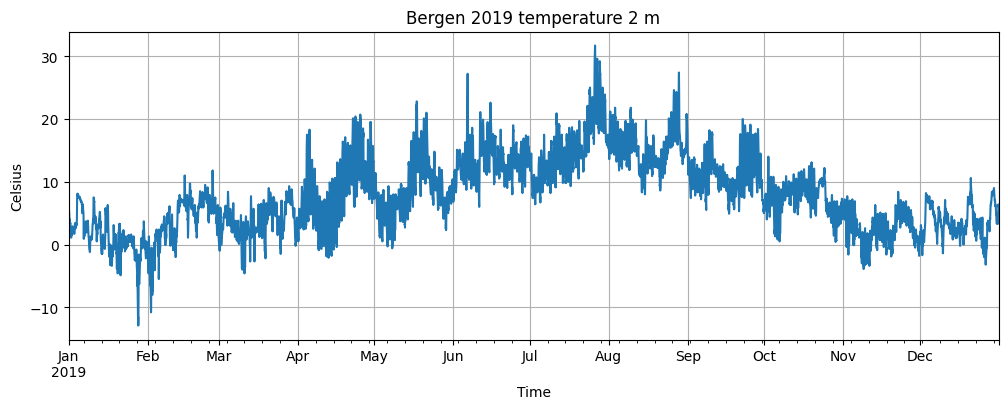

In [5]:
ax = df_bergen_2019["temperature_2m"].astype(float).plot(title="Bergen 2019 temperature 2 m")
ax.set_xlabel("Time")
ax.set_ylabel("Celsius")
plt.show()


## DCT high pass helper
Build SATV by removing low frequency content.

In [6]:
def dct_highpass(series: pd.Series, cutoff=30) -> pd.Series:
    x = series.values.astype(float)
    n = len(x)
    
    # Check if all values are NaN
    if np.isnan(x).all():
        return pd.Series(np.zeros(n), index=series.index)
    
    # Interpolate missing values if any exist
    if np.isnan(x).any():
        idx = np.arange(n)
        ok = np.isfinite(x)
        x = x.copy()
        x[~ok] = np.interp(idx[~ok], idx[ok], x[ok])
    
    # Validate cutoff parameter
    if cutoff >= n:
        cutoff = max(1, n // 2)
    
    X = dct(x, norm="ortho")
    X[:cutoff] = 0.0
    x_hp = idct(X, norm="ortho")
    return pd.Series(x_hp, index=series.index)


## Temperature outliers with SPC
Use SATV for robust bounds. Return plot and outlier table.


In [7]:
def temperature_spc_plot(df: pd.DataFrame, temp_col="temperature_2m",
                         cutoff=30, k_sigma=3.5, baseline_window_hours=24*14):
    temp = df[temp_col].astype(float)
    satv = dct_highpass(temp, cutoff=cutoff)

    med = np.median(satv.values)
    mad = np.median(np.abs(satv.values - med))
    sigma = 1.4826 * mad if mad > 0 else satv.std(ddof=0)

    lower = med - k_sigma * sigma
    upper = med + k_sigma * sigma
    is_out = (satv < lower) | (satv > upper)

    baseline = temp.rolling(window=baseline_window_hours, min_periods=1, center=True).mean()
    b_lower = baseline + (lower - med)
    b_upper = baseline + (upper - med)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(temp.index, temp.values, label="Temperature 2 m")
    ax.plot(b_lower.index, b_lower.values, linewidth=1, label="SPC lower")
    ax.plot(b_upper.index, b_upper.values, linewidth=1, label="SPC upper")
    ax.scatter(temp.index[is_out], temp.values[is_out], s=12, label="Outliers")
    ax.set_title("Temperature outliers via DCT high pass and robust SPC")
    ax.set_xlabel("Time")
    ax.set_ylabel("Celsius")
    ax.legend(loc="best")
    fig.tight_layout()

    out_df = pd.DataFrame({
        "time": temp.index[is_out],
        "temperature_2m": temp.values[is_out]
    }).reset_index(drop=True)

    return fig, out_df

def spc_summary(out_df: pd.DataFrame) -> pd.DataFrame:
    if len(out_df) > 0:
        earliest = pd.to_datetime(out_df["time"]).min()
        latest = pd.to_datetime(out_df["time"]).max()
    else:
        earliest = pd.NaT
        latest = pd.NaT
    
    return pd.DataFrame({
        "num_outliers": [len(out_df)],
        "earliest": [earliest],
        "latest": [latest]
    })


### SPC test and summary
Run once with sensible defaults.

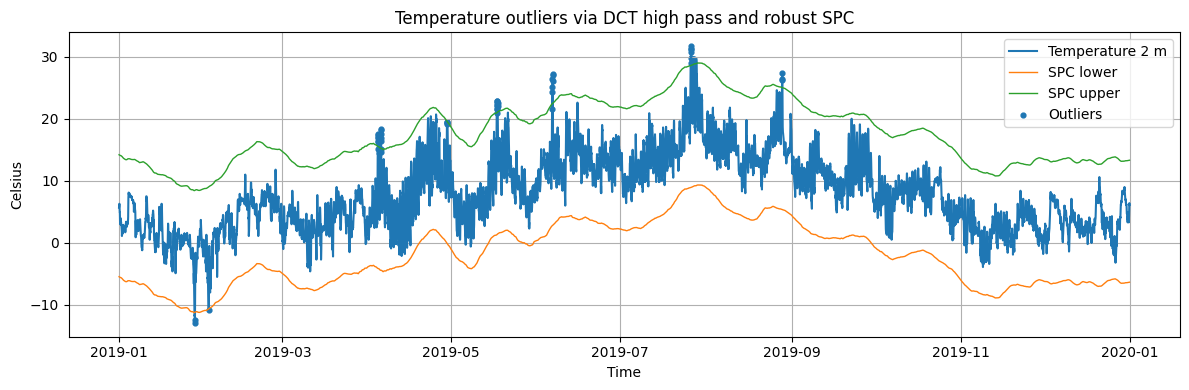

,num_outliers,earliest,latest
0,53,2019-01-28 09:00:00,2019-08-28 14:00:00


In [8]:
fig_temp, out_temp = temperature_spc_plot(df_bergen_2019, cutoff=30, k_sigma=3.5)
display(fig_temp); plt.close(fig_temp)
spc_summary(out_temp)

## Precipitation plot
Precipitation is a sum per hour.


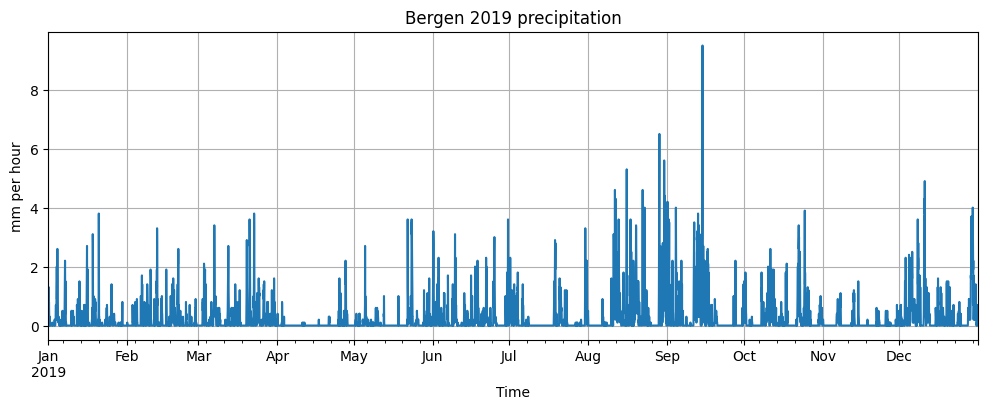

In [9]:
ax = df_bergen_2019["precipitation"].astype(float).plot(title="Bergen 2019 precipitation")
ax.set_xlabel("Time")
ax.set_ylabel("mm per hour")
plt.show()


## Precipitation anomalies with LOF
Use current value, 3h sum, 24h sum. Return plot and anomaly table.

In [10]:
def precipitation_lof_plot(df: pd.DataFrame, precip_col="precipitation",
                           contamination=0.01, n_neighbors=35):
    p = df[precip_col].astype(float).fillna(0.0)
    roll3 = p.rolling(3, min_periods=1).sum()
    roll24 = p.rolling(24, min_periods=1).sum()
    X = np.c_[p.values, roll3.values, roll24.values]
    mask = np.all(np.isfinite(X), axis=1)
    X = X[mask]
    t_idx = p.index[mask]

    nn = int(n_neighbors)
    if len(X) < 3:
        raise ValueError("Too few valid rows for LOF")
    nn = max(2, min(nn, len(X) - 1))

    lof = LocalOutlierFactor(n_neighbors=nn, contamination=float(contamination))
    y_pred = lof.fit_predict(X)
    is_out = y_pred == -1

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(t_idx, p.loc[t_idx].values, label="Precipitation mm")
    ax.scatter(t_idx[is_out], p.loc[t_idx[is_out]].values, s=12, label="Anomalies")
    ax.set_title(f"Precipitation anomalies via LOF (contamination={contamination})")
    ax.set_xlabel("Time")
    ax.set_ylabel("mm per hour")
    ax.legend(loc="best")
    fig.tight_layout()

    out_df = pd.DataFrame({"time": t_idx[is_out], "precipitation": p.loc[t_idx[is_out]].values}).reset_index(drop=True)
    return fig, out_df


def lof_summary(out_df: pd.DataFrame) -> pd.DataFrame:
    if len(out_df) > 0:
        earliest = pd.to_datetime(out_df["time"]).min()
        latest = pd.to_datetime(out_df["time"]).max()
    else:
        earliest = pd.NaT
        latest = pd.NaT
    
    return pd.DataFrame({
        "num_anomalies": [len(out_df)],
        "earliest": [earliest],
        "latest": [latest]
    })


### LOF test and summary
Run once with defaults.

/Users/youneshansen/Documents/ind320/ind320-yohan3351/.venv312/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


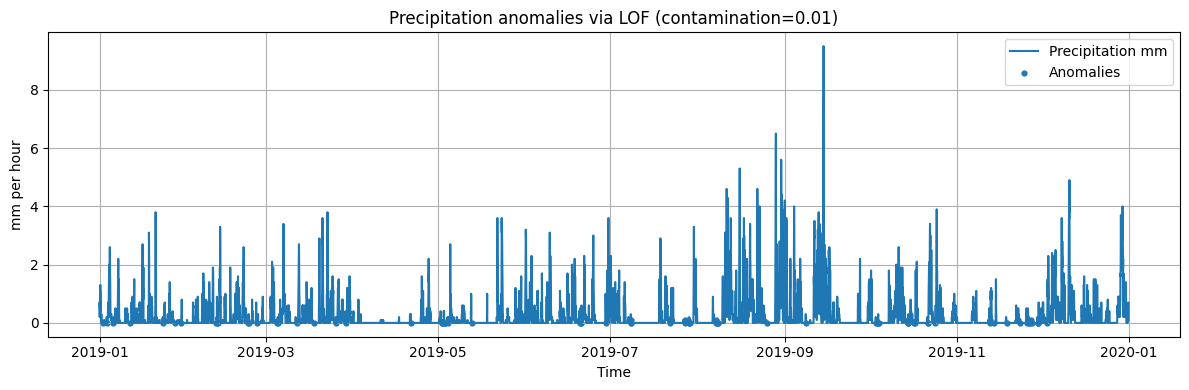

,num_anomalies,earliest,latest
0,87,2019-01-02 07:00:00,2019-12-19 10:00:00


In [11]:
fig_p, out_p = precipitation_lof_plot(df_bergen_2019, contamination=0.01, n_neighbors=35)
display(fig_p); plt.close(fig_p)
lof_summary(out_p)


## Elhub production loader
Download one year, normalize fields, and convert to analysis schema.


In [12]:
import time
from datetime import datetime, timedelta, timezone

BASE = "https://api.elhub.no/energy-data/v0"
ENTITY = "price-areas"
DATASET = "PRODUCTION_PER_GROUP_MBA_HOUR"

def _iso_offset(dt: datetime) -> str:
    return dt.strftime("%Y-%m-%dT%H:%M:%S+00:00")

def _fetch_chunk(start_dt: datetime, end_dt: datetime):
    url = f"{BASE}/{ENTITY}"
    params = {"dataset": DATASET, "startDate": _iso_offset(start_dt), "endDate": _iso_offset(end_dt)}
    r = requests.get(url, params=params, timeout=60)
    if r.ok:
        return 200, r.json(), None
    return r.status_code, None, r.text[:400]

def _normalize_production(js) -> pd.DataFrame:
    rows = []
    for item in js.get("data", []) or []:
        attrs = item.get("attributes", {}) or {}
        area = attrs.get("name") or attrs.get("eic")
        for rec in attrs.get("productionPerGroupMbaHour", []) or []:
            rows.append((
                area,
                rec.get("productionGroup"),
                rec.get("startTime") or rec.get("start"),
                rec.get("quantityKwh") or rec.get("kWh") or rec.get("quantity")
            ))
    df = pd.DataFrame(rows, columns=["priceArea","productionGroup","startTime","quantityKwh"])
    df["startTime"] = pd.to_datetime(df["startTime"], utc=True, errors="coerce")
    df["quantityKwh"] = pd.to_numeric(df["quantityKwh"], errors="coerce")
    return df

def download_elhub_production_utc(year: int) -> pd.DataFrame:
    year_start = datetime(year,   1, 1, tzinfo=timezone.utc)
    year_end   = datetime(year+1, 1, 1, tzinfo=timezone.utc)
    parts = []
    cursor = year_start
    while cursor < year_end:
        month_end = (cursor + timedelta(days=32)).replace(day=1, hour=0, minute=0, second=0, microsecond=0, tzinfo=timezone.utc)
        end_dt = min(month_end, year_end)
        code, jsm, err = _fetch_chunk(cursor, end_dt)
        if code == 200 and jsm:
            parts.append(_normalize_production(jsm))
            print(f"OK {cursor.date()}..{end_dt.date()}")
            cursor = end_dt
            time.sleep(0.2)
            continue
        print(f"Monthly failed {cursor.date()}..{end_dt.date()} code={code}, trying weekly")
        wk = cursor
        while wk < end_dt:
            wk_end = min(wk + timedelta(days=7), end_dt)
            c2, jsw, err2 = _fetch_chunk(wk, wk_end)
            if c2 == 200 and jsw:
                parts.append(_normalize_production(jsw))
                print(f"  OK {wk.date()}..{wk_end.date()}")
                time.sleep(0.2)
            else:
                raise RuntimeError(f"Weekly failed {wk}..{wk_end} code={c2} err={err2}")
            wk = wk_end
        cursor = end_dt
    if not parts:
        return pd.DataFrame(columns=["priceArea","productionGroup","startTime","quantityKwh"])
    df = pd.concat(parts, ignore_index=True)
    df = df[(df["startTime"] >= pd.Timestamp(f"{year}-01-01", tz="UTC")) &
            (df["startTime"] <  pd.Timestamp(f"{year+1}-01-01", tz="UTC"))].copy()
    df = df.rename(columns={
        "priceArea": "price_area",
        "productionGroup": "group",
        "startTime": "time_utc",
        "quantityKwh": "value_kwh"
    })
    return df.reset_index(drop=True)

def elhub_to_portfolio_schema(df_utc: pd.DataFrame, to_local: bool = True) -> pd.DataFrame:
    ts = df_utc["time_utc"]
    if to_local:
        ts = ts.dt.tz_convert("Europe/Oslo")
    out = pd.DataFrame({
        "time": ts,
        "price_area": df_utc["price_area"],
        "group": df_utc["group"],
        "value": df_utc["value_kwh"].astype(float)
    })
    return out


### Download 2021 and adapt
Create the analysis table and validate.

In [13]:
raw_elhub_2021 = download_elhub_production_utc(2021)
elhub = elhub_to_portfolio_schema(raw_elhub_2021, to_local=True)
display(elhub.head())
print("Rows:", len(elhub), "Columns:", list(elhub.columns))

need = {"time","price_area","group","value"}
assert need <= set(elhub.columns)
assert elhub["time"].dt.tz is not None
print("elhub OK")



OK 2021-01-01..2021-02-01
OK 2021-02-01..2021-03-01
OK 2021-02-01..2021-03-01
OK 2021-03-01..2021-04-01
OK 2021-03-01..2021-04-01
OK 2021-04-01..2021-05-01
OK 2021-04-01..2021-05-01
OK 2021-05-01..2021-06-01
OK 2021-05-01..2021-06-01
OK 2021-06-01..2021-07-01
OK 2021-06-01..2021-07-01
OK 2021-07-01..2021-08-01
OK 2021-07-01..2021-08-01
OK 2021-08-01..2021-09-01
OK 2021-08-01..2021-09-01
OK 2021-09-01..2021-10-01
OK 2021-09-01..2021-10-01
OK 2021-10-01..2021-11-01
OK 2021-10-01..2021-11-01
OK 2021-11-01..2021-12-01
OK 2021-11-01..2021-12-01
OK 2021-12-01..2022-01-01
OK 2021-12-01..2022-01-01


,time,price_area,group,value
0,2021-01-01 01:00:00+01:00,NO1,hydro,2494728.0
1,2021-01-01 02:00:00+01:00,NO1,hydro,2486777.5
2,2021-01-01 03:00:00+01:00,NO1,hydro,2461176.0
3,2021-01-01 04:00:00+01:00,NO1,hydro,2466969.2
4,2021-01-01 05:00:00+01:00,NO1,hydro,2467460.0


Rows: 215329 Columns: ['time', 'price_area', 'group', 'value']
elhub OK


## STL on Elhub
Regularize to hourly, fill small gaps, fit STL with safe windows.


In [14]:
def stl_decompose_elhub(df: pd.DataFrame,
                        price_area: str = "NO5",
                        production_group: str = "hydro",
                        period: int = 24,
                        seasonal: int = 13,
                        trend: int = 365,
                        robust: bool = True):
    pa = price_area.strip().upper()
    grp = production_group.strip().lower()

    sel = df[(df["price_area"].astype(str).str.upper() == pa) &
             (df["group"].astype(str).str.lower() == grp)].copy()
    if sel.empty:
        raise ValueError(f"No rows for area={price_area} group={production_group}")

    sel = sel.sort_values("time").set_index("time")
    start, end = sel.index.min(), sel.index.max()
    hourly_index = pd.date_range(start=start, end=end, freq="h", tz=sel.index.tz)
    y = sel["value"].reindex(hourly_index).interpolate(limit=6).bfill().ffill()

    if len(y) < max(period, seasonal, trend) + 10:
        raise ValueError(f"Series too short for STL. Length {len(y)}")

    stl = STL(y, period=int(period),
              seasonal=int(seasonal), trend=int(trend),
              robust=bool(robust))
    res = stl.fit()

    fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    ax[0].plot(res.observed); ax[0].set_title(f"Observed {pa} {grp}")
    ax[1].plot(res.trend);    ax[1].set_title("Trend")
    ax[2].plot(res.seasonal); ax[2].set_title("Seasonal")
    ax[3].plot(res.resid);    ax[3].set_title("Remainder")
    fig.tight_layout()
    return fig, res


### STL test
Use odd windows to avoid errors.


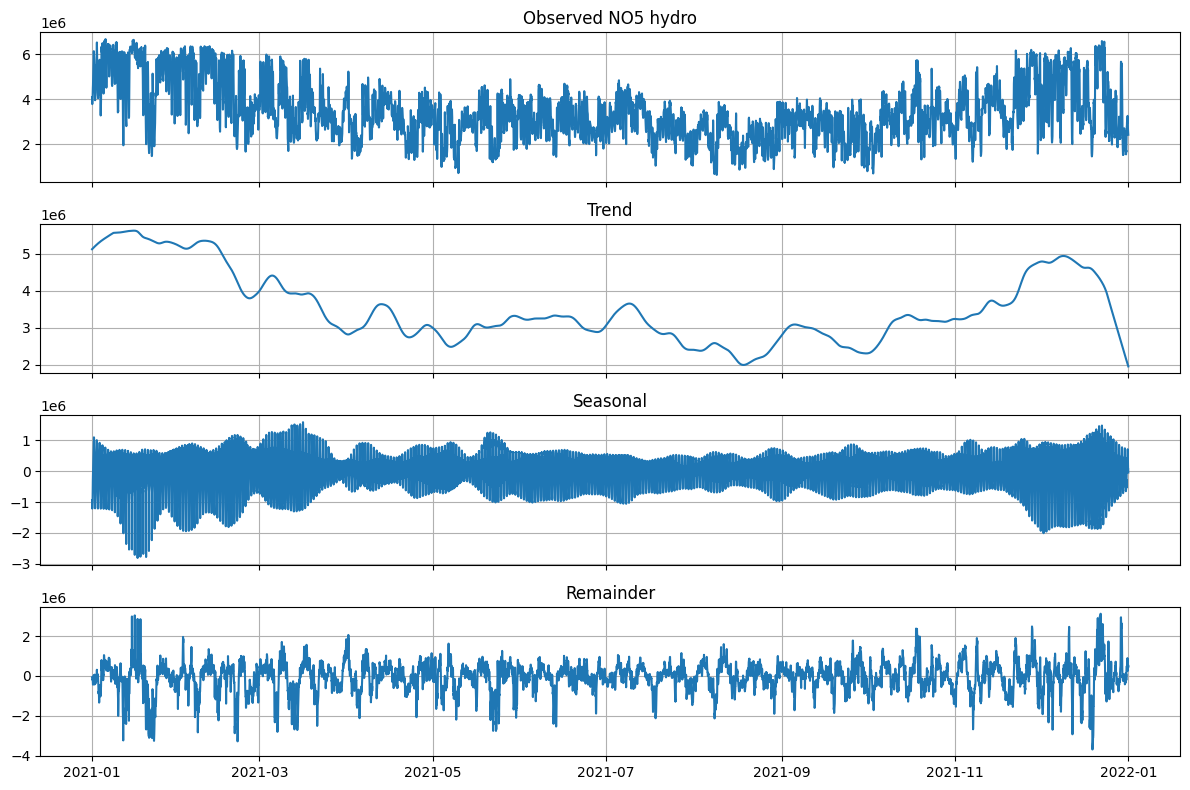

In [15]:
seasonal_eff = 13 if 13 % 2 == 1 else 14
trend_eff = 365 if 365 % 2 == 1 else 366
fig_stl, res_stl = stl_decompose_elhub(
    elhub, price_area="NO5", production_group="hydro",
    period=24, seasonal=seasonal_eff, trend=trend_eff, robust=True
)
display(fig_stl); plt.close(fig_stl)


## Spectrogram on Elhub
Short time Fourier spectrogram on an hourly series.


In [16]:
def spectrogram_elhub(df: pd.DataFrame,
                      price_area: str = "NO5",
                      production_group: str = "hydro",
                      window_len: int = 256,
                      overlap: int = 128,
                      figsize=(12, 4)):
    pa = price_area.strip().upper()
    grp = production_group.strip().lower()

    sel = df[(df["price_area"].astype(str).str.upper() == pa) &
             (df["group"].astype(str).str.lower() == grp)].copy()
    if sel.empty:
        raise ValueError(f"No rows for area={price_area} group={production_group}")

    sel = sel.sort_values("time").set_index("time")
    start, end = sel.index.min(), sel.index.max()
    hourly_index = pd.date_range(start=start, end=end, freq="h", tz=sel.index.tz)
    y = sel["value"].reindex(hourly_index).interpolate(limit=6).bfill().ffill().values

    nperseg = int(window_len)
    noverlap = int(overlap)
    if noverlap >= nperseg:
        noverlap = max(0, nperseg // 2)

    f, t, Sxx = _scipy_spectrogram(y, fs=1.0, nperseg=nperseg, noverlap=noverlap,
                                   scaling="density", mode="magnitude")

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.pcolormesh(t, f, Sxx, shading="auto")
    ax.set_title(f"Spectrogram for {grp} in {pa}")
    ax.set_xlabel("Time index")
    ax.set_ylabel("Frequency, cycles per hour")
    fig.colorbar(im, ax=ax, label="Magnitude")
    fig.tight_layout()
    return fig, {"f": f, "t": t, "shape": Sxx.shape}


### Spectrogram test
Default window and overlap.

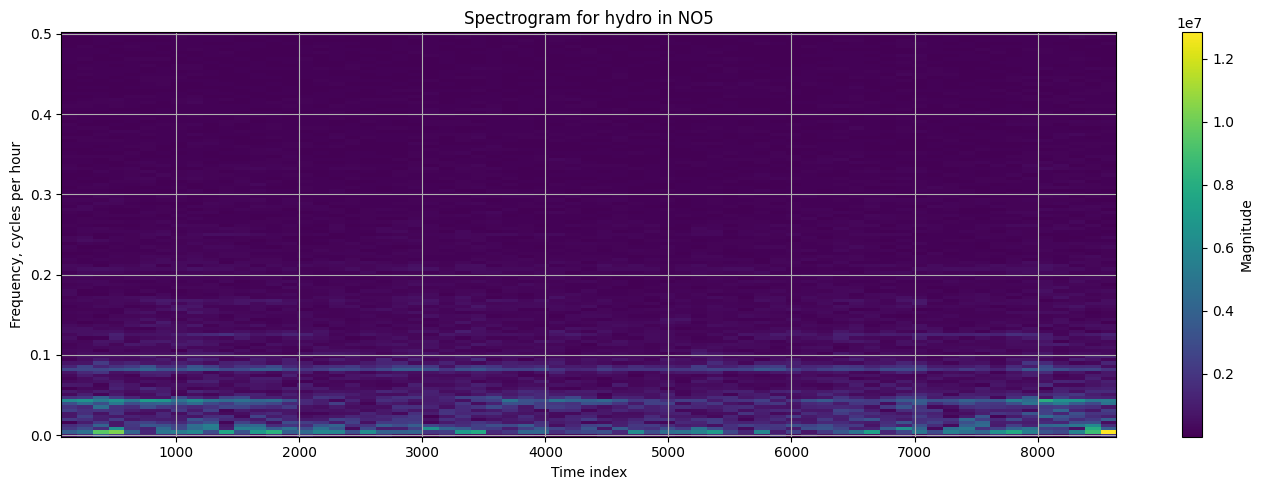

Spectrogram meta: {'f': 129, 't': 67, 'shape': (129, 67)}


In [17]:
fig_spec, meta_spec = spectrogram_elhub(
    elhub, price_area="NO5", production_group="hydro",
    window_len=256, overlap=128, figsize=(14, 5)
)
display(fig_spec); plt.close(fig_spec)
print("Spectrogram meta:", {k: (len(v) if k in ["f","t"] else v) for k,v in meta_spec.items()})


## AI usage
I used chatgpt5 as a tutor for the specifics of the task and as a code assistant through github copilot. It helped me understand the specifics of the task and helped with the design of the jupyter notebook and streamlit app. I got code templates for ERA5 downloads and Elhub loading, caching, timezone handling, and input checks. For the analysis it suggested functions with safe defaults, hourly regularization, and odd window guards. It also helped me implement DCT high pass SPC method and the LOF based precipitation anomaly detector. I instructed it to fix the STL odd window error and overlap limits in spectrograms for better user experience.


## Development log

I started by listing the tasks and set the section order for the notebook. I built a small table for the five cities to fix coordinates for the API calls. For ERA5 I used the open meteo archive endpoint and returned the columns from the CSV from part 1 and tested on Bergen 2019.

For outliers in temperature I filtered out slow swings to focus on short spikes, then drew control bands around a rolling baseline and marked points outside as outliers. Cutoff and sigma are simple sliders with sensible defaults, and the code is wrapped in a small function that returns a figure and a short summary, without plotting the intermediate series. 

For precipitation I used a neighborhood based method to flag unusual periods, with a default of 1 percent flagged, also wrapped in a helper that returns a plot and summary. 

For Elhub I built a downloader that walks through the year in monthly windows with a weekly fallback, then cleaned the payload into a tidy table and a simple schema with time, area, group, and value, and set time to Europe Oslo. STL runs after aligning the data to hourly and filling small gaps, with guarded window sizes, and the spectrogram uses a standard short time view with adjustable window length and overlap.

I commented the code to make it easily reusable. I ran the notebook top to bottom and verified the outputs before export to PDF. The Streamlit app uses the same ideas, but moved UI to pages with tabs. I switched from CSV to the API for weather and added summary tables for SPC and LOF. I hit a few issues, including Elhub rate limits that needed retries and a weekly fallback, STL complaining that seasonal windows must be odd, and UTC vs Oslo time conversions causing off by one day checks that I corrected.


# IND320 Part 3, Jupyter Notebook

This notebook covers:
1) Cities and price areas for Norway  
2) ERA5 historical downloader and Bergen 2019 example  
3) Temperature outliers using DCT high pass with robust SPC  
4) Precipitation anomalies using LOF  
5) STL decomposition on elhub production data  
6) Spectrogram on elhub production data


In [18]:
# Global imports for the whole notebook

# Core
import os
import time
from datetime import datetime, timedelta, timezone

# Data and math
import numpy as np
import pandas as pd

# HTTP
import requests

# Plotting
import matplotlib.pyplot as plt

# Stats and ML
from statsmodels.tsa.seasonal import STL
from sklearn.neighbors import LocalOutlierFactor

# Signals
from scipy.fftpack import dct, idct
from scipy.signal import spectrogram as _scipy_spectrogram

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

print("Imports OK")


Imports OK


## Cities and price areas

One city per price area. Store code, city, lon, lat.



In [19]:
# Price areas with representative city center coordinates
areas = [
    {"price_area": "NO1", "city": "Oslo",         "lat": 59.9139,  "lon": 10.7522},
    {"price_area": "NO2", "city": "Kristiansand", "lat": 58.1467,  "lon": 7.9956},
    {"price_area": "NO3", "city": "Trondheim",    "lat": 63.4305,  "lon": 10.3951},
    {"price_area": "NO4", "city": "Tromsø",       "lat": 69.6492,  "lon": 18.9553},
    {"price_area": "NO5", "city": "Bergen",       "lat": 60.39299, "lon": 5.32415},
]

city_df = pd.DataFrame(areas, columns=["price_area", "city", "lon", "lat"])
city_df


,price_area,city,lon,lat
0,NO1,Oslo,10.75220,59.91390
1,NO2,Kristiansand,7.99560,58.14670
2,NO3,Trondheim,10.39510,63.43050
3,NO4,Tromsø,18.95530,69.64920
4,NO5,Bergen,5.32415,60.39299


## ERA5 downloader
Function that returns hourly ERA5 for a year with CSV compatible columns from part 1.


In [20]:
def download_era5_csv_compatible(lon: float, lat: float, year: int, tz: str = "Europe/Oslo") -> pd.DataFrame:
    hourly_vars = [
        "temperature_2m",
        "precipitation",
        "wind_speed_10m",
        "wind_gusts_10m",
        "wind_direction_10m",
    ]
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude":  lat,
        "longitude": lon,
        "start_date": f"{year}-01-01",
        "end_date":   f"{year}-12-31",
        "hourly":     ",".join(hourly_vars),
        "timezone":   tz,
        "wind_speed_unit": "ms",
        "timeformat": "iso8601",
    }
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()

    time = pd.to_datetime(data["hourly"]["time"])
    df = pd.DataFrame(index=time)
    for v in hourly_vars:
        df[v] = data["hourly"].get(v, [np.nan] * len(time))
    df.index.name = "time"
    df = df.sort_index()

    rename_map = {
        "temperature_2m": "temperature_2m (°C)",
        "precipitation": "precipitation (mm)",
        "wind_speed_10m": "wind_speed_10m (m/s)",
        "wind_gusts_10m": "wind_gusts_10m (m/s)",
        "wind_direction_10m": "wind_direction_10m (°)",
    }
    df = df.rename(columns=rename_map).reset_index()

    desired_cols = [
        "time",
        "temperature_2m (°C)",
        "precipitation (mm)",
        "wind_speed_10m (m/s)",
        "wind_gusts_10m (m/s)",
        "wind_direction_10m (°)",
    ]
    return df[desired_cols]



## Bergen 2019
Download ERA5 for Bergen 2019, then create an analysis friendly copy.


In [21]:
bergen = city_df.loc[city_df["city"] == "Bergen"].iloc[0]
lon, lat = float(bergen["lon"]), float(bergen["lat"])

df_bergen_2019_csv = download_era5_csv_compatible(lon, lat, 2019)
display(df_bergen_2019_csv.head())
print("CSV compatible columns:", list(df_bergen_2019_csv.columns))
print("Rows:", len(df_bergen_2019_csv))

rename_map = {
    "temperature_2m (°C)": "temperature_2m",
    "precipitation (mm)": "precipitation",
    "wind_speed_10m (m/s)": "wind_speed_10m",
    "wind_gusts_10m (m/s)": "wind_gusts_10m",
    "wind_direction_10m (°)": "wind_direction_10m",
}
df_bergen_2019 = (
    df_bergen_2019_csv
    .rename(columns=rename_map)
    .assign(time=lambda d: pd.to_datetime(d["time"]))
    .set_index("time")
    .sort_index()
)
df_bergen_2019.head()


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
0,2019-01-01 00:00:00,5.7,0.7,10.27,27.7,263
1,2019-01-01 01:00:00,5.8,0.2,11.40,29.8,278
2,2019-01-01 02:00:00,6.1,0.7,11.68,31.1,286
3,2019-01-01 03:00:00,6.3,0.5,11.36,29.4,298
4,2019-01-01 04:00:00,5.8,1.1,11.46,30.6,315


CSV compatible columns: ['time', 'temperature_2m (°C)', 'precipitation (mm)', 'wind_speed_10m (m/s)', 'wind_gusts_10m (m/s)', 'wind_direction_10m (°)']
Rows: 8760


,temperature_2m,precipitation,wind_speed_10m,wind_gusts_10m,wind_direction_10m
time,,,,,
2019-01-01 00:00:00,5.7,0.7,10.27,27.7,263
2019-01-01 01:00:00,5.8,0.2,11.40,29.8,278
2019-01-01 02:00:00,6.1,0.7,11.68,31.1,286
2019-01-01 03:00:00,6.3,0.5,11.36,29.4,298
2019-01-01 04:00:00,5.8,1.1,11.46,30.6,315


## Temperature plot
Plot temperature as a function of time.


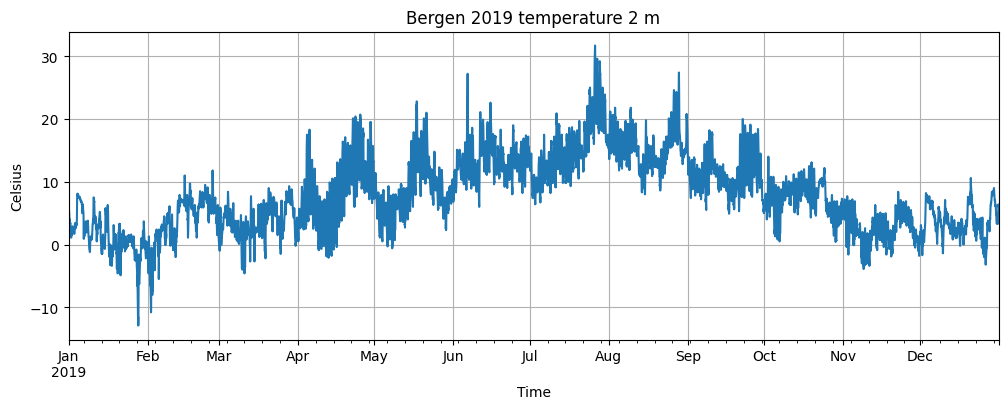

In [22]:
ax = df_bergen_2019["temperature_2m"].astype(float).plot(title="Bergen 2019 temperature 2 m")
ax.set_xlabel("Time")
ax.set_ylabel("Celsius")
plt.show()


## DCT high pass helper
Build SATV by removing low frequency content.

In [23]:
def dct_highpass(series: pd.Series, cutoff=30) -> pd.Series:
    x = series.values.astype(float)
    n = len(x)
    
    # Check if all values are NaN
    if np.isnan(x).all():
        return pd.Series(np.zeros(n), index=series.index)
    
    # Interpolate missing values if any exist
    if np.isnan(x).any():
        idx = np.arange(n)
        ok = np.isfinite(x)
        x = x.copy()
        x[~ok] = np.interp(idx[~ok], idx[ok], x[ok])
    
    # Validate cutoff parameter
    if cutoff >= n:
        cutoff = max(1, n // 2)
    
    X = dct(x, norm="ortho")
    X[:cutoff] = 0.0
    x_hp = idct(X, norm="ortho")
    return pd.Series(x_hp, index=series.index)


## Temperature outliers with SPC
Use SATV for robust bounds. Return plot and outlier table.


In [24]:
def temperature_spc_plot(df: pd.DataFrame, temp_col="temperature_2m",
                         cutoff=30, k_sigma=3.5, baseline_window_hours=24*14):
    temp = df[temp_col].astype(float)
    satv = dct_highpass(temp, cutoff=cutoff)

    med = np.median(satv.values)
    mad = np.median(np.abs(satv.values - med))
    sigma = 1.4826 * mad if mad > 0 else satv.std(ddof=0)

    lower = med - k_sigma * sigma
    upper = med + k_sigma * sigma
    is_out = (satv < lower) | (satv > upper)

    baseline = temp.rolling(window=baseline_window_hours, min_periods=1, center=True).mean()
    b_lower = baseline + (lower - med)
    b_upper = baseline + (upper - med)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(temp.index, temp.values, label="Temperature 2 m")
    ax.plot(b_lower.index, b_lower.values, linewidth=1, label="SPC lower")
    ax.plot(b_upper.index, b_upper.values, linewidth=1, label="SPC upper")
    ax.scatter(temp.index[is_out], temp.values[is_out], s=12, label="Outliers")
    ax.set_title("Temperature outliers via DCT high pass and robust SPC")
    ax.set_xlabel("Time")
    ax.set_ylabel("Celsius")
    ax.legend(loc="best")
    fig.tight_layout()

    out_df = pd.DataFrame({
        "time": temp.index[is_out],
        "temperature_2m": temp.values[is_out]
    }).reset_index(drop=True)

    return fig, out_df

def spc_summary(out_df: pd.DataFrame) -> pd.DataFrame:
    if len(out_df) > 0:
        earliest = pd.to_datetime(out_df["time"]).min()
        latest = pd.to_datetime(out_df["time"]).max()
    else:
        earliest = pd.NaT
        latest = pd.NaT
    
    return pd.DataFrame({
        "num_outliers": [len(out_df)],
        "earliest": [earliest],
        "latest": [latest]
    })


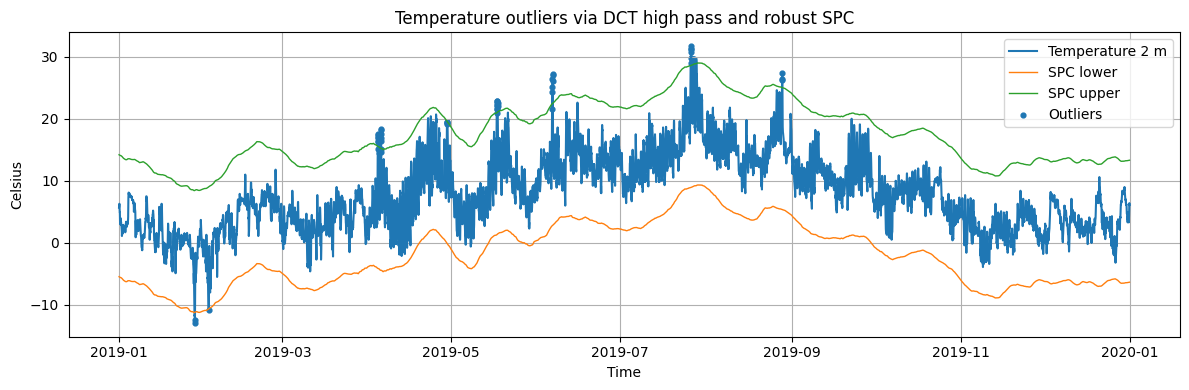

,num_outliers,earliest,latest
0,53,2019-01-28 09:00:00,2019-08-28 14:00:00


In [25]:
fig_temp, out_temp = temperature_spc_plot(df_bergen_2019, cutoff=30, k_sigma=3.5)
display(fig_temp); plt.close(fig_temp)
spc_summary(out_temp)

## Precipitation plot
Precipitation is a sum per hour.


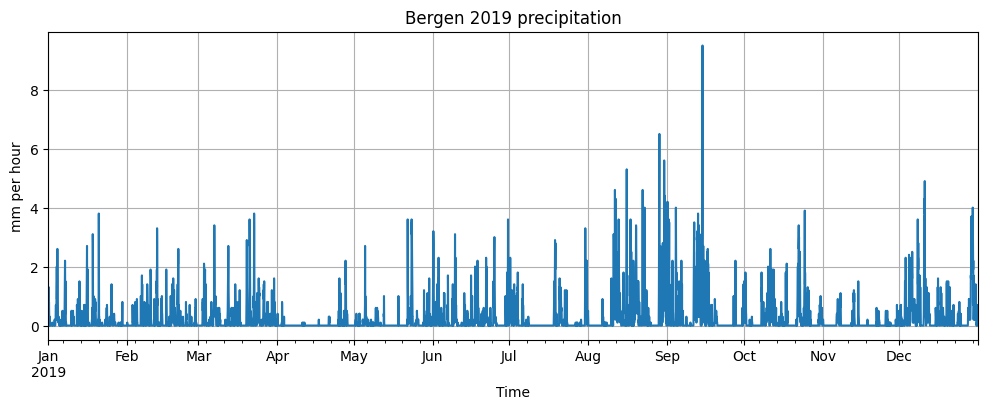

In [26]:
ax = df_bergen_2019["precipitation"].astype(float).plot(title="Bergen 2019 precipitation")
ax.set_xlabel("Time")
ax.set_ylabel("mm per hour")
plt.show()


## Precipitation anomalies with LOF
Use current value, 3h sum, 24h sum. Return plot and anomaly table.

In [27]:
def precipitation_lof_plot(df: pd.DataFrame, precip_col="precipitation",
                           contamination=0.01, n_neighbors=35):
    p = df[precip_col].astype(float).fillna(0.0)
    roll3 = p.rolling(3, min_periods=1).sum()
    roll24 = p.rolling(24, min_periods=1).sum()
    X = np.c_[p.values, roll3.values, roll24.values]

    lof = LocalOutlierFactor(n_neighbors=int(n_neighbors), contamination=float(contamination))
    y_pred = lof.fit_predict(X)
    is_out = y_pred == -1

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(p.index, p.values, label="Precipitation mm")
    ax.scatter(p.index[is_out], p.values[is_out], s=12, label="Anomalies")
    ax.set_title(f"Precipitation anomalies via LOF (contamination={contamination})")
    ax.set_xlabel("Time")
    ax.set_ylabel("mm per hour")
    ax.legend(loc="best")
    fig.tight_layout()

    out_df = pd.DataFrame({"time": p.index[is_out], "precipitation": p.values[is_out]}).reset_index(drop=True)
    return fig, out_df

def lof_summary(out_df: pd.DataFrame) -> pd.DataFrame:
    if len(out_df) > 0:
        earliest = pd.to_datetime(out_df["time"]).min()
        latest = pd.to_datetime(out_df["time"]).max()
    else:
        earliest = pd.NaT
        latest = pd.NaT
    
    return pd.DataFrame({
        "num_anomalies": [len(out_df)],
        "earliest": [earliest],
        "latest": [latest]
    })


/Users/youneshansen/Documents/ind320/ind320-yohan3351/.venv312/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


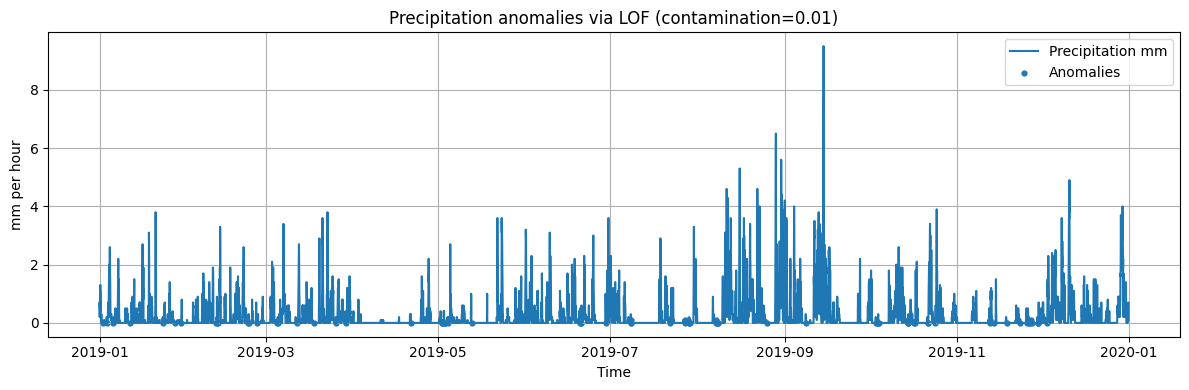

,num_anomalies,earliest,latest
0,87,2019-01-02 07:00:00,2019-12-19 10:00:00


In [28]:
fig_p, out_p = precipitation_lof_plot(df_bergen_2019, contamination=0.01, n_neighbors=35)
display(fig_p); plt.close(fig_p)
lof_summary(out_p)


## Elhub production loader
Download one year, normalize fields, and convert to analysis schema.


In [29]:
# Imports used by the Elhub loader
import time
from datetime import datetime, timedelta, timezone



### Helpers - API constants and JSON normalizer


In [30]:
import time
from datetime import datetime, timedelta, timezone

BASE = "https://api.elhub.no/energy-data/v0"
ENTITY = "price-areas"
DATASET = "PRODUCTION_PER_GROUP_MBA_HOUR"

def _iso_offset(dt: datetime) -> str:
    return dt.strftime("%Y-%m-%dT%H:%M:%S+00:00")

def _fetch_chunk(start_dt: datetime, end_dt: datetime):
    url = f"{BASE}/{ENTITY}"
    params = {"dataset": DATASET, "startDate": _iso_offset(start_dt), "endDate": _iso_offset(end_dt)}
    r = requests.get(url, params=params, timeout=60)
    if r.ok:
        return 200, r.json(), None
    return r.status_code, None, r.text[:400]

def _normalize_production(js) -> pd.DataFrame:
    rows = []
    for item in js.get("data", []) or []:
        attrs = item.get("attributes", {}) or {}
        area = attrs.get("name") or attrs.get("eic")
        for rec in attrs.get("productionPerGroupMbaHour", []) or []:
            rows.append((
                area,
                rec.get("productionGroup"),
                rec.get("startTime") or rec.get("start"),
                rec.get("quantityKwh") or rec.get("kWh") or rec.get("quantity")
            ))
    df = pd.DataFrame(rows, columns=["priceArea","productionGroup","startTime","quantityKwh"])
    df["startTime"] = pd.to_datetime(df["startTime"], utc=True, errors="coerce")
    df["quantityKwh"] = pd.to_numeric(df["quantityKwh"], errors="coerce")
    return df

def download_elhub_production_utc(year: int) -> pd.DataFrame:
    year_start = datetime(year,   1, 1, tzinfo=timezone.utc)
    year_end   = datetime(year+1, 1, 1, tzinfo=timezone.utc)
    parts = []
    cursor = year_start
    while cursor < year_end:
        month_end = (cursor + timedelta(days=32)).replace(day=1, hour=0, minute=0, second=0, microsecond=0, tzinfo=timezone.utc)
        end_dt = min(month_end, year_end)
        code, jsm, err = _fetch_chunk(cursor, end_dt)
        if code == 200 and jsm:
            parts.append(_normalize_production(jsm))
            print(f"OK {cursor.date()}..{end_dt.date()}")
            cursor = end_dt
            time.sleep(0.2)
            continue
        print(f"Monthly failed {cursor.date()}..{end_dt.date()} code={code}, trying weekly")
        wk = cursor
        while wk < end_dt:
            wk_end = min(wk + timedelta(days=7), end_dt)
            c2, jsw, err2 = _fetch_chunk(wk, wk_end)
            if c2 == 200 and jsw:
                parts.append(_normalize_production(jsw))
                print(f"  OK {wk.date()}..{wk_end.date()}")
                time.sleep(0.2)
            else:
                raise RuntimeError(f"Weekly failed {wk}..{wk_end} code={c2} err={err2}")
            wk = wk_end
        cursor = end_dt
    if not parts:
        return pd.DataFrame(columns=["priceArea","productionGroup","startTime","quantityKwh"])
    df = pd.concat(parts, ignore_index=True)
    df = df[(df["startTime"] >= pd.Timestamp(f"{year}-01-01", tz="UTC")) &
            (df["startTime"] <  pd.Timestamp(f"{year+1}-01-01", tz="UTC"))].copy()
    df = df.rename(columns={
        "priceArea": "price_area",
        "productionGroup": "group",
        "startTime": "time_utc",
        "quantityKwh": "value_kwh"
    })
    return df.reset_index(drop=True)

def elhub_to_portfolio_schema(df_utc: pd.DataFrame, to_local: bool = True) -> pd.DataFrame:
    ts = df_utc["time_utc"]
    if to_local:
        ts = ts.dt.tz_convert("Europe/Oslo")
    out = pd.DataFrame({
        "time": ts,
        "price_area": df_utc["price_area"],
        "group": df_utc["group"],
        "value": df_utc["value_kwh"].astype(float)
    })
    return out


### Downloader - one calendar year with monthly windows and weekly fallback



In [31]:
def download_elhub_production_utc(year: int) -> pd.DataFrame:
    """
    Download one full year of production data in UTC.
    Returns columns: price_area, group, time_utc, value_kwh
    """
    year_start = datetime(year,   1, 1, tzinfo=timezone.utc)
    year_end   = datetime(year+1, 1, 1, tzinfo=timezone.utc)

    parts = []
    cursor = year_start
    while cursor < year_end:
        month_end = (cursor + timedelta(days=32)).replace(
            day=1, hour=0, minute=0, second=0, microsecond=0, tzinfo=timezone.utc
        )
        end_dt = min(month_end, year_end)

        code, jsm, err = _fetch_chunk(cursor, end_dt)
        if code == 200 and jsm:
            parts.append(_normalize_production(jsm))
            print(f"OK {cursor.date()}..{end_dt.date()}")
            cursor = end_dt
            time.sleep(0.2)
            continue

        print(f"Monthly failed {cursor.date()}..{end_dt.date()} code={code}, trying weekly")
        wk = cursor
        while wk < end_dt:
            wk_end = min(wk + timedelta(days=7), end_dt)
            c2, jsw, err2 = _fetch_chunk(wk, wk_end)
            if c2 == 200 and jsw:
                parts.append(_normalize_production(jsw))
                print(f"  OK {wk.date()}..{wk_end.date()}")
                time.sleep(0.2)
            else:
                raise RuntimeError(f"Weekly failed {wk}..{wk_end} code={c2} err={err2}")
            wk = wk_end
        cursor = end_dt

    if not parts:
        return pd.DataFrame(columns=["priceArea","productionGroup","startTime","quantityKwh"])

    df = pd.concat(parts, ignore_index=True)

    # clamp to the year
    df = df[(df["startTime"] >= pd.Timestamp(f"{year}-01-01", tz="UTC")) &
            (df["startTime"] <  pd.Timestamp(f"{year+1}-01-01", tz="UTC"))].copy()

    # tidy names for the analysis schema
    df = df.rename(columns={
        "priceArea": "price_area",
        "productionGroup": "group",
        "startTime": "time_utc",
        "quantityKwh": "value_kwh"
    })
    return df.reset_index(drop=True)


### Adapter - convert UTC raw to portfolio schema used by STL and spectrogram


In [32]:
def elhub_to_portfolio_schema(df_utc: pd.DataFrame, to_local: bool = True) -> pd.DataFrame:
    """
    Output columns:
      time (tz aware, Europe/Oslo if to_local True, else UTC)
      price_area
      group
      value
    """
    ts = df_utc["time_utc"]
    if to_local:
        ts = ts.dt.tz_convert("Europe/Oslo")
    out = pd.DataFrame({
        "time": ts,
        "price_area": df_utc["price_area"],
        "group": df_utc["group"],
        "value": df_utc["value_kwh"].astype(float)
    })
    return out


### Download 2021 and adapt
Create the analysis table and validate.

In [33]:
raw_elhub_2021 = download_elhub_production_utc(2021)
elhub = elhub_to_portfolio_schema(raw_elhub_2021, to_local=True)
display(elhub.head())
print("Rows:", len(elhub), "Columns:", list(elhub.columns))

need = {"time","price_area","group","value"}
assert need <= set(elhub.columns)
assert elhub["time"].dt.tz is not None
print("elhub OK")



OK 2021-01-01..2021-02-01
OK 2021-02-01..2021-03-01
OK 2021-02-01..2021-03-01
OK 2021-03-01..2021-04-01
OK 2021-03-01..2021-04-01
OK 2021-04-01..2021-05-01
OK 2021-04-01..2021-05-01
OK 2021-05-01..2021-06-01
OK 2021-05-01..2021-06-01
OK 2021-06-01..2021-07-01
OK 2021-06-01..2021-07-01
OK 2021-07-01..2021-08-01
OK 2021-07-01..2021-08-01
OK 2021-08-01..2021-09-01
OK 2021-08-01..2021-09-01
OK 2021-09-01..2021-10-01
OK 2021-09-01..2021-10-01
OK 2021-10-01..2021-11-01
OK 2021-10-01..2021-11-01
OK 2021-11-01..2021-12-01
OK 2021-11-01..2021-12-01
OK 2021-12-01..2022-01-01
OK 2021-12-01..2022-01-01


,time,price_area,group,value
0,2021-01-01 01:00:00+01:00,NO1,hydro,2494728.0
1,2021-01-01 02:00:00+01:00,NO1,hydro,2486777.5
2,2021-01-01 03:00:00+01:00,NO1,hydro,2461176.0
3,2021-01-01 04:00:00+01:00,NO1,hydro,2466969.2
4,2021-01-01 05:00:00+01:00,NO1,hydro,2467460.0


Rows: 215329 Columns: ['time', 'price_area', 'group', 'value']
elhub OK


## STL on Elhub
Regularize to hourly, fill small gaps, fit STL with safe windows.


In [34]:
def stl_decompose_elhub(df: pd.DataFrame,
                        price_area: str = "NO5",
                        production_group: str = "hydro",
                        period: int = 24,
                        seasonal: int = 13,
                        trend: int = 365,
                        robust: bool = True):
    pa = price_area.strip().upper()
    grp = production_group.strip().lower()

    sel = df[(df["price_area"].astype(str).str.upper() == pa) &
             (df["group"].astype(str).str.lower() == grp)].copy()
    if sel.empty:
        raise ValueError(f"No rows for area={price_area} group={production_group}")

    sel = sel.sort_values("time").set_index("time")
    start, end = sel.index.min(), sel.index.max()
    hourly_index = pd.date_range(start=start, end=end, freq="h", tz=sel.index.tz)
    y = sel["value"].reindex(hourly_index).interpolate(limit=6).bfill().ffill()

    if len(y) < max(period, seasonal, trend) + 10:
        raise ValueError(f"Series too short for STL. Length {len(y)}")

    stl = STL(y, period=int(period),
              seasonal=int(seasonal), trend=int(trend),
              robust=bool(robust))
    res = stl.fit()

    fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    ax[0].plot(res.observed); ax[0].set_title(f"Observed {pa} {grp}")
    ax[1].plot(res.trend);    ax[1].set_title("Trend")
    ax[2].plot(res.seasonal); ax[2].set_title("Seasonal")
    ax[3].plot(res.resid);    ax[3].set_title("Remainder")
    fig.tight_layout()
    return fig, res


### STL test
Use odd windows to avoid errors.


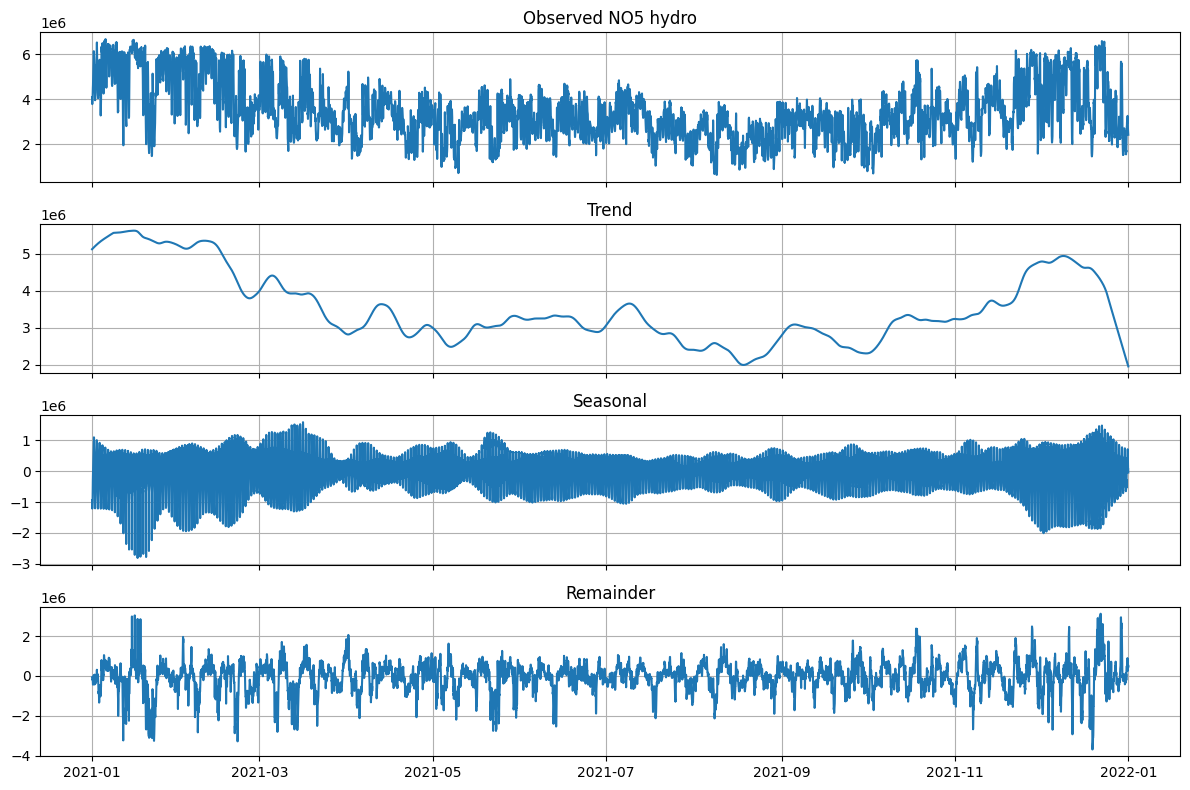

In [35]:
seasonal_eff = 13 if 13 % 2 == 1 else 14
trend_eff = 365 if 365 % 2 == 1 else 366
fig_stl, res_stl = stl_decompose_elhub(
    elhub, price_area="NO5", production_group="hydro",
    period=24, seasonal=seasonal_eff, trend=trend_eff, robust=True
)
display(fig_stl); plt.close(fig_stl)


## Spectrogram on Elhub
Short time Fourier spectrogram on an hourly series.


In [36]:
def spectrogram_elhub(df: pd.DataFrame,
                      price_area: str = "NO5",
                      production_group: str = "hydro",
                      window_len: int = 256,
                      overlap: int = 128,
                      figsize=(12, 4)):
    pa = price_area.strip().upper()
    grp = production_group.strip().lower()

    sel = df[(df["price_area"].astype(str).str.upper() == pa) &
             (df["group"].astype(str).str.lower() == grp)].copy()
    if sel.empty:
        raise ValueError(f"No rows for area={price_area} group={production_group}")

    sel = sel.sort_values("time").set_index("time")
    start, end = sel.index.min(), sel.index.max()
    hourly_index = pd.date_range(start=start, end=end, freq="h", tz=sel.index.tz)
    y = sel["value"].reindex(hourly_index).interpolate(limit=6).bfill().ffill().values

    nperseg = int(window_len)
    noverlap = int(overlap)
    if noverlap >= nperseg:
        noverlap = max(0, nperseg // 2)

    f, t, Sxx = _scipy_spectrogram(y, fs=1.0, nperseg=nperseg, noverlap=noverlap,
                                   scaling="density", mode="magnitude")

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.pcolormesh(t, f, Sxx, shading="auto")
    ax.set_title(f"Spectrogram for {grp} in {pa}")
    ax.set_xlabel("Time index")
    ax.set_ylabel("Frequency, cycles per hour")
    fig.colorbar(im, ax=ax, label="Magnitude")
    fig.tight_layout()
    return fig, {"f": f, "t": t, "shape": Sxx.shape}


### Spectrogram test
Default window and overlap.

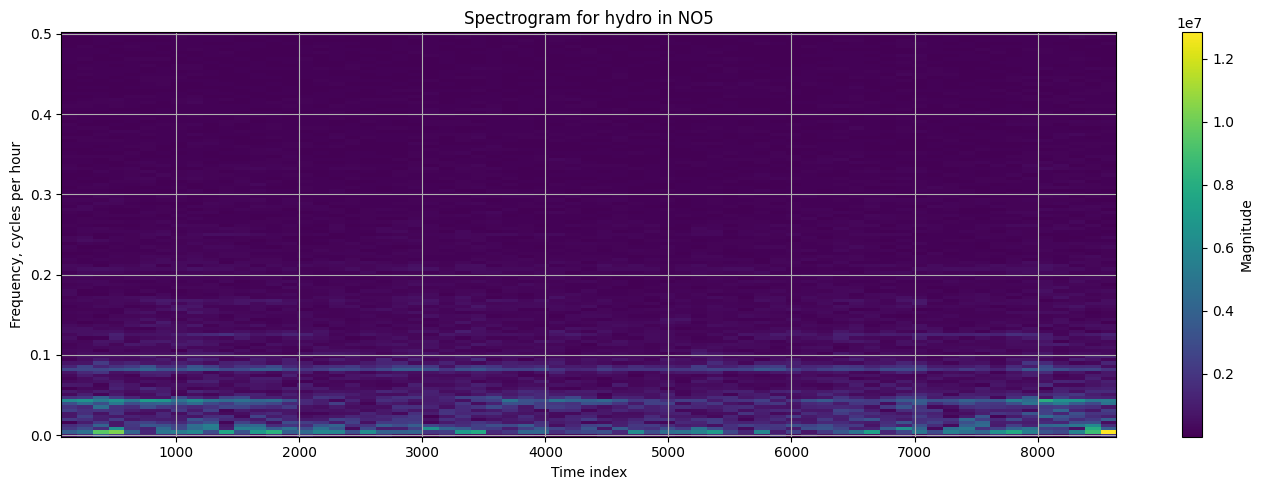

Spectrogram meta: {'f': 129, 't': 67, 'shape': (129, 67)}


In [37]:
fig_spec, meta_spec = spectrogram_elhub(
    elhub, price_area="NO5", production_group="hydro",
    window_len=256, overlap=128, figsize=(14, 5)
)
display(fig_spec); plt.close(fig_spec)
print("Spectrogram meta:", {k: (len(v) if k in ["f","t"] else v) for k,v in meta_spec.items()})


## AI usage
I used chatgpt5 as a tutor for the specifics of the task and as a code assistant through github copilot. It helped me understand the specifics of the task and helped with the design of the jupyter notebook and streamlit app. I got code templates for ERA5 downloads and Elhub loading, caching, timezone handling, and input checks. For the analysis it suggested functions with safe defaults, hourly regularization, and odd window guards. It also helped me implement DCT high pass SPC method and the LOF based precipitation anomaly detector. I instructed it to fix the STL odd window error and overlap limits in spectrograms for better user experience.


## Development log

I started by listing the tasks and set the section order for the notebook. I built a small table for the five cities to fix coordinates for the API calls. For ERA5 I used the open meteo archive endpoint and returned the columns from the CSV from part 1 and tested on Bergen 2019.

For outliers in temperature I filtered out slow swings to focus on short spikes, then drew control bands around a rolling baseline and marked points outside as outliers. Cutoff and sigma are simple sliders with sensible defaults, and the code is wrapped in a small function that returns a figure and a short summary, without plotting the intermediate series. 

For precipitation I used a neighborhood based method to flag unusual periods, with a default of 1 percent flagged, also wrapped in a helper that returns a plot and summary. 

For Elhub I built a downloader that walks through the year in monthly windows with a weekly fallback, then cleaned the payload into a tidy table and a simple schema with time, area, group, and value, and set time to Europe Oslo. STL runs after aligning the data to hourly and filling small gaps, with guarded window sizes, and the spectrogram uses a standard short time view with adjustable window length and overlap.

I commented the code to make it easily reusable. I ran the notebook top to bottom and verified the outputs before export to PDF. The Streamlit app uses the same ideas, but moved UI to pages with tabs. I switched from CSV to the API for weather and added summary tables for SPC and LOF. I hit a few issues, including Elhub rate limits that needed retries and a weekly fallback, STL complaining that seasonal windows must be odd, and UTC vs Oslo time conversions causing off by one day checks that I corrected.


## Links

- GitHub repository: https://github.com/youneshansen/ind320-yohan3351  
- Streamlit app: https://ind320-yohan3351.streamlit.app/

